# Sensitivity of the Beam Factor to different choices

In this notebook, we look at the beam factor computed for the Nature Paper day 260,
in comparison to Alan's beam factor, and explore what happens when we change 
some of the options. 

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from edges_cal import modelling as mdl

from edges_analysis import beams, const, sky_models

%load_ext autoreload
%autoreload 2

In [19]:
plt.style.use("seaborn-dark")

In [3]:
alans_beam = beams.Beam.from_file(
    band="low",
    beam_file="/data4/nmahesh/edges/code_from_alan_org/newniv.txt",
    rotation_from_north=-6,
)
alan_beam_factor = np.genfromtxt(
    "/data4/nmahesh/edges/alans-pipeline/scripts/H2Case/beamcorr_626.txt"
)

### Fiducial Case

In [4]:
lst_list = np.arange(23.95244823089913, 35.7, 0.50441) % 24
assert len(lst_list) == 24

In [5]:
defaults = dict(
    beam=alans_beam,
    f_low=40 * u.MHz,
    f_high=100 * u.MHz,
    lsts=lst_list,
    sky_model=sky_models.Haslam408AllNoh(),
    index_model=sky_models.ConstantIndex(),
    normalize_beam=False,
    ground_loss_file=None,
    reference_frequency=75 * u.MHz,
    beam_smoothing=False,
    interp_kind="nearest",
    freq_progress=False,
    location=const.KNOWN_LOCATIONS["alan-edges"],
    sky_at_reference_frequency=False,
    use_astropy_azel=False,
)

In [6]:
default = beams.antenna_beam_factor(**defaults)

24LST [01:06,  2.78s/LST]


In [8]:
use_astropy_azel = beams.antenna_beam_factor(**{**defaults, "use_astropy_azel": True})

0LST [00:00, ?LST/s]

24LST [01:18,  3.27s/LST]


In [9]:
sky_at_ref_freq = beams.antenna_beam_factor(
    **{**defaults, "sky_at_reference_frequency": True}
)

0LST [00:00, ?LST/s]

24LST [01:04,  2.68s/LST]


In [10]:
exact_location = beams.antenna_beam_factor(
    **{**defaults, "location": const.KNOWN_LOCATIONS["edges"]}
)

24LST [01:06,  2.78s/LST]


In [11]:
linear_interp = beams.antenna_beam_factor(**{**defaults, "interp_kind": "linear"})

24LST [01:18,  3.26s/LST]


In [12]:
gauss_index = beams.antenna_beam_factor(
    **{**defaults, "index_model": sky_models.GaussianIndex()}
)

24LST [01:19,  3.29s/LST]


In [13]:
haslam_model = beams.antenna_beam_factor(
    **{**defaults, "sky_model": sky_models.Haslam408()}
)

24LST [07:22, 18.45s/LST]


In [14]:
lst_plus_5min = beams.antenna_beam_factor(**{**defaults, "lsts": lst_list + 5 / 60})

24LST [01:06,  2.76s/LST]


In [15]:
lst_minus_5min = beams.antenna_beam_factor(**{**defaults, "lsts": lst_list - 5 / 60})

0LST [00:00, ?LST/s]

24LST [01:06,  2.78s/LST]


In [16]:
fourier = mdl.Fourier(
    n_terms=31,
    transform=mdl.ShiftTransform(shift=75.0),
    period=1.2 * default.nfreq * (default.frequencies[1] - default.frequencies[0]),
)

In [24]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

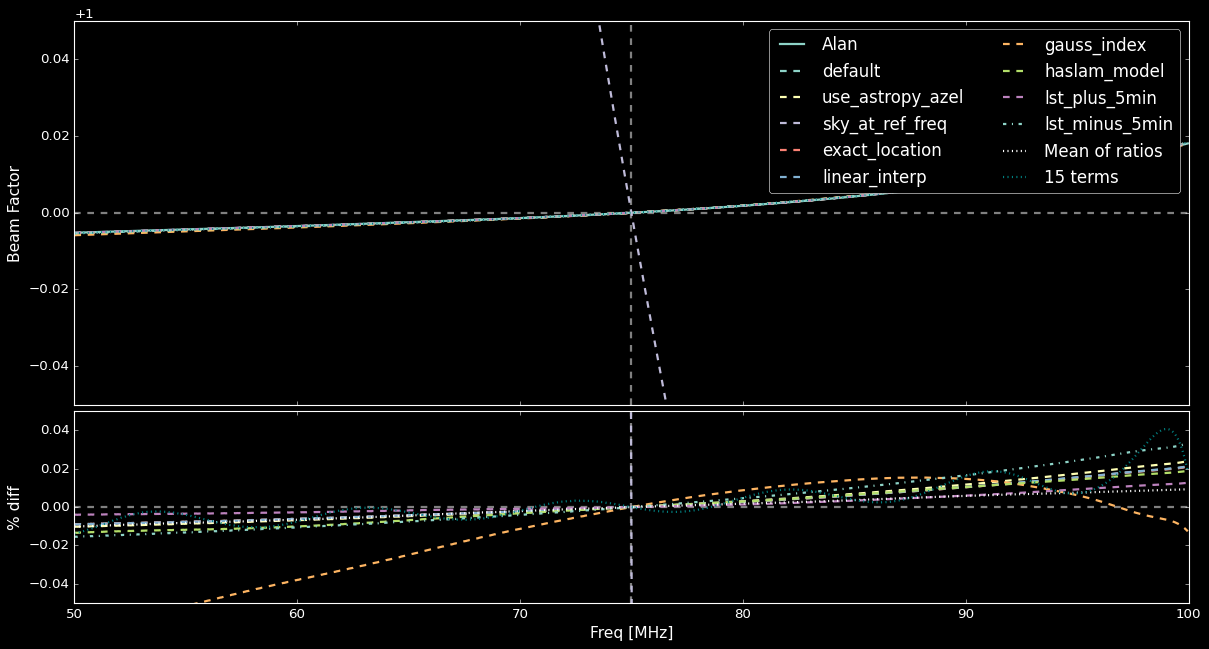

In [28]:
fig, ax = plt.subplots(
    2,
    1,
    sharex=True,
    constrained_layout=True,
    figsize=(15, 8),
    gridspec_kw={"height_ratios": (2, 1)},
)

ax[0].plot(alan_beam_factor[:, 0], 1 / alan_beam_factor[:, 3], label="Alan", ls="-")

ax[1].set_ylabel("% diff", fontsize=14)
ax[1].set_xlabel("Freq [MHz]", fontsize=14)
ax[0].axvline(75.0, ls="--", color="gray")
ax[1].axvline(75.0, ls="--", color="gray")
ax[0].axhline(1.0, ls="--", color="gray")
ax[1].axhline(0.0, ls="--", color="gray")
ax[0].set_ylabel("Beam Factor", fontsize=14)

try:
    del thing
except NameError:
    pass

stuff = {k: v for k, v in locals().items() if isinstance(v, beams.BeamFactor)}
for i, (name, thing) in enumerate(stuff.items()):
    integrated_beam_factor = thing.get_integrated_beam_factor(
        fourier, alan_beam_factor[:, 0]
    )
    style = dict(color=f"C{i % 8}", ls=["--", "-.", ":"][i // 8])
    ax[0].plot(alan_beam_factor[:, 0], integrated_beam_factor, label=name, **style)
    ax[1].plot(
        alan_beam_factor[:, 0],
        100 * (integrated_beam_factor * alan_beam_factor[:, 3] - 1),
        **style,
    )

# Also, evaluate the beam factor using mean of ratios...
beam_factor = default.get_mean_beam_factor(fourier, alan_beam_factor[:, 0])
ax[0].plot(
    alan_beam_factor[:, 0], beam_factor, label="Mean of ratios", color="white", ls=":"
)
ax[1].plot(
    alan_beam_factor[:, 0],
    100 * (beam_factor * alan_beam_factor[:, 3] - 1),
    color="white",
    ls=":",
)

# And use a different number of terms in the model...
fourier15 = mdl.Fourier(
    n_terms=15,
    transform=mdl.ShiftTransform(shift=75.0),
    period=1.2 * default.nfreq * (default.frequencies[1] - default.frequencies[0]),
)
beam_factor = default.get_integrated_beam_factor(fourier15, alan_beam_factor[:, 0])
ax[0].plot(alan_beam_factor[:, 0], beam_factor, label="15 terms", color="teal", ls=":")
ax[1].plot(
    alan_beam_factor[:, 0],
    100 * (beam_factor * alan_beam_factor[:, 3] - 1),
    color="teal",
    ls=":",
)

ax[0].plot()
ax[0].legend(fontsize=15, ncol=2)
ax[0].set_ylim(0.95, 1.05)
ax[1].set_ylim(-0.05, 0.05)
ax[0].grid(False)
ax[1].grid(False)